In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
batch_size = 128
lr = 0.0002
z_dim = 100        # latent vector size
epochs = 20
num_classes = 10   # Fashion-MNIST has 10 classes
img_size = 28 * 28

In [ ]:
device = torch.device("cpu")

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # scale to [-1, 1]
])

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.49MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.2MB/s]


In [ ]:
label_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print(f"Dataset loaded: {len(train_dataset)} images")

Dataset loaded: 60000 images


In [ ]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, img_size),
            nn.Tanh()  # outputs in [-1, 1]
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

In [ ]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(-1, img_size)
        return self.model(img_flat)

Epoch [1/20] | D loss: 0.2959 | G loss: 1.1849
Epoch [2/20] | D loss: 0.1706 | G loss: 3.1445


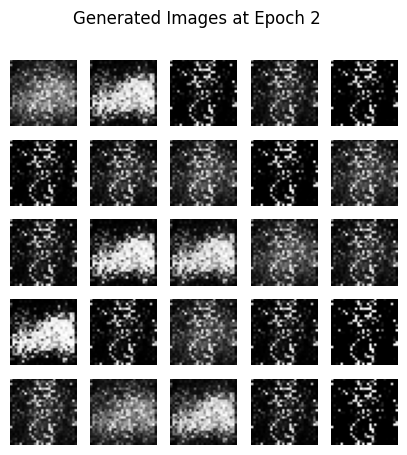

Epoch [3/20] | D loss: 0.2009 | G loss: 1.5319
Epoch [4/20] | D loss: 0.3571 | G loss: 1.3809


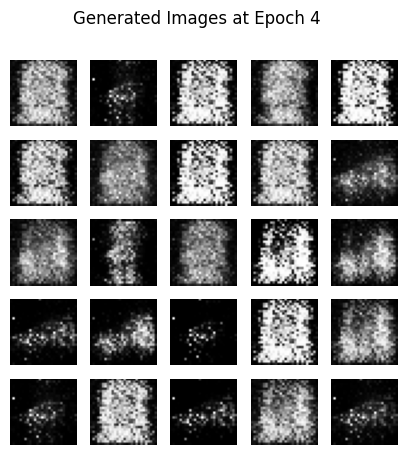

Epoch [5/20] | D loss: 0.5862 | G loss: 4.0260
Epoch [6/20] | D loss: 0.3899 | G loss: 1.4332


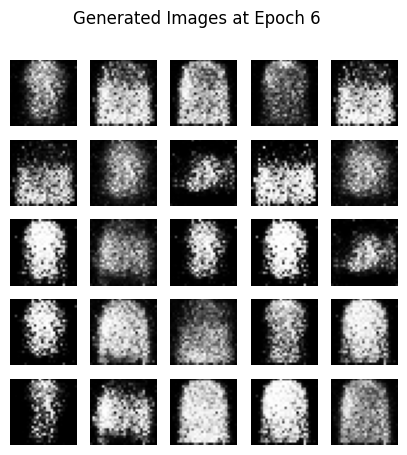

Epoch [7/20] | D loss: 0.4455 | G loss: 1.0012
Epoch [8/20] | D loss: 0.4551 | G loss: 1.0492


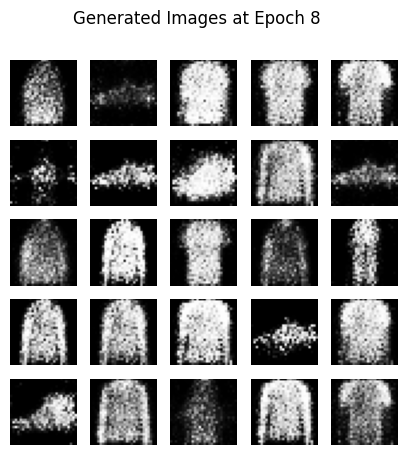

Epoch [9/20] | D loss: 0.5041 | G loss: 0.9746
Epoch [10/20] | D loss: 0.5118 | G loss: 1.3284


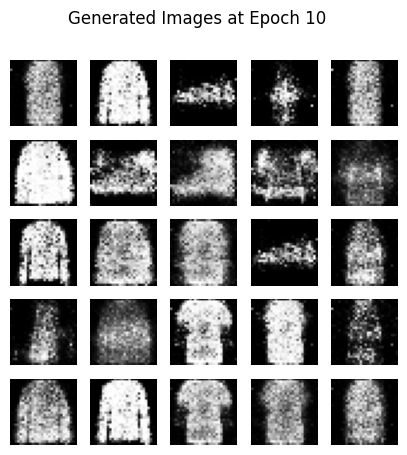

Epoch [11/20] | D loss: 0.4542 | G loss: 1.1375
Epoch [12/20] | D loss: 0.6226 | G loss: 0.9251


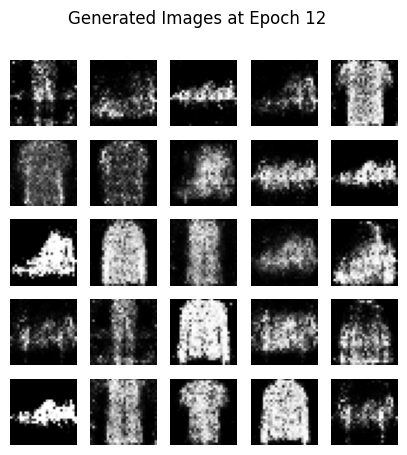

Epoch [13/20] | D loss: 0.6540 | G loss: 0.6319
Epoch [14/20] | D loss: 0.5601 | G loss: 0.9396


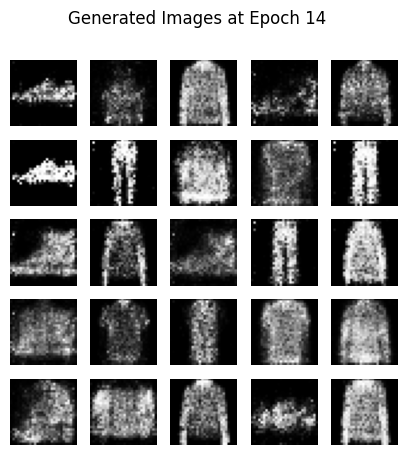

Epoch [15/20] | D loss: 0.5377 | G loss: 1.2815
Epoch [16/20] | D loss: 0.6257 | G loss: 1.0633


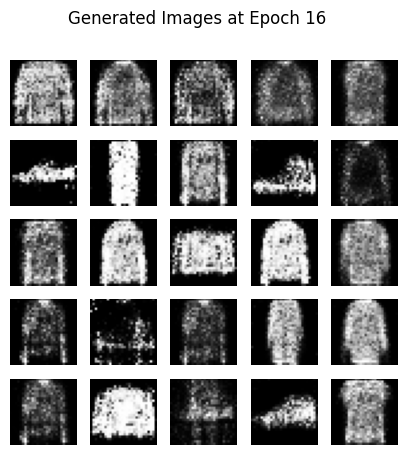

Epoch [17/20] | D loss: 0.6057 | G loss: 0.8995
Epoch [18/20] | D loss: 0.5459 | G loss: 1.1938


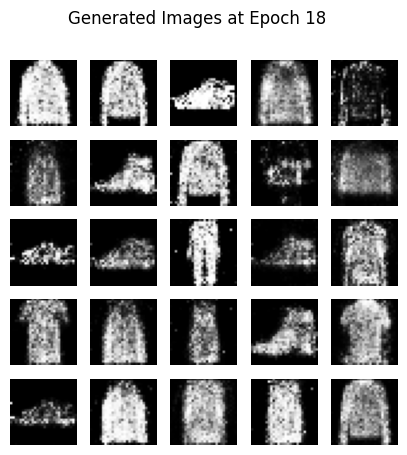

Epoch [19/20] | D loss: 0.6026 | G loss: 1.0853
Epoch [20/20] | D loss: 0.5973 | G loss: 1.1047


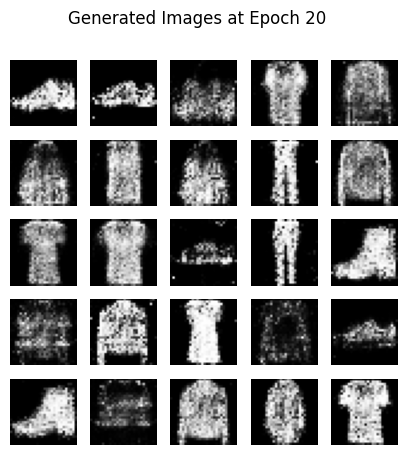

In [ ]:
# Initialize models
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


def save_generated_images(generator, epoch, n_samples=25):
    """Helper function to visualize generated images"""
    z = torch.randn(n_samples, z_dim).to(device)
    gen_imgs = generator(z).detach().cpu()
    gen_imgs = gen_imgs * 0.5 + 0.5  # de-normalize to [0,1]

    fig, axes = plt.subplots(5, 5, figsize=(5, 5))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(gen_imgs[i][0], cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Generated Images at Epoch {epoch}")
    plt.show()


# Training Loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):

        # Ground truth labels
        real = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        # --------------------
        # Train Generator
        # --------------------
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), z_dim).to(device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), real)  # fool discriminator
        g_loss.backward()
        optimizer_G.step()

        # --------------------
        # Train Discriminator
        # --------------------
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(imgs.to(device)), real)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

    # Save sample images every 2 epochs
    if (epoch + 1) % 2 == 0:
        save_generated_images(generator, epoch+1)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
batch_size = 128
lr = 0.0002
z_dim = 100
epochs = 20
num_classes = 10
img_size = 28 * 28
device = torch.device("cpu")

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # scale to [-1,1]
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Dataset loaded:", len(train_dataset), "images")

Dataset loaded: 60000 images


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_size):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)  # one-hot-like embeddings
        self.model = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, img_size),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # concatenate noise + label
        c = self.label_emb(labels)
        x = torch.cat([z, c], dim=1)
        img = self.model(x)
        return img.view(-1, 1, 28, 28)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(img_size + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        c = self.label_emb(labels)
        x = torch.cat([img_flat, c], dim=1)
        return self.model(x)


In [ ]:
generator = Generator(z_dim, num_classes, img_size).to(device)
discriminator = Discriminator(num_classes, img_size).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
def save_generated_images(generator, epoch, n_samples=10):
    generator.eval()
    fig, axes = plt.subplots(num_classes, n_samples, figsize=(n_samples, num_classes))
    for label in range(num_classes):
        z = torch.randn(n_samples, z_dim).to(device)
        labels = torch.full((n_samples,), label, dtype=torch.long).to(device)
        gen_imgs = generator(z, labels).detach().cpu()
        gen_imgs = gen_imgs * 0.5 + 0.5  # rescale to [0,1]
        for i in range(n_samples):
            axes[label, i].imshow(gen_imgs[i][0], cmap="gray")
            axes[label, i].axis("off")
    plt.suptitle(f"CGAN Generated Images at Epoch {epoch}")
    plt.show()
    generator.train()

Epoch [1/20] | D loss: 0.2567 | G loss: 1.9075
Epoch [2/20] | D loss: 0.0672 | G loss: 2.8839
Epoch [3/20] | D loss: 0.2198 | G loss: 2.8459
Epoch [4/20] | D loss: 0.5922 | G loss: 3.8978
Epoch [5/20] | D loss: 0.3594 | G loss: 1.4257


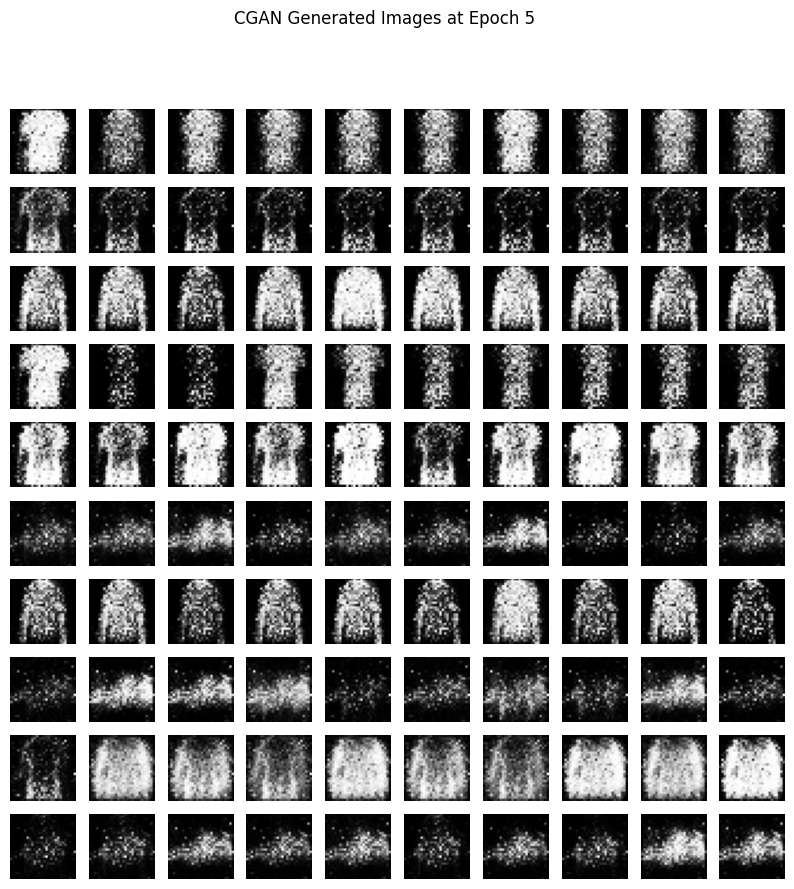

Epoch [6/20] | D loss: 0.5348 | G loss: 0.6333
Epoch [7/20] | D loss: 0.6263 | G loss: 2.1413
Epoch [8/20] | D loss: 0.4918 | G loss: 1.1261
Epoch [9/20] | D loss: 0.5758 | G loss: 1.6672
Epoch [10/20] | D loss: 0.5282 | G loss: 0.9517


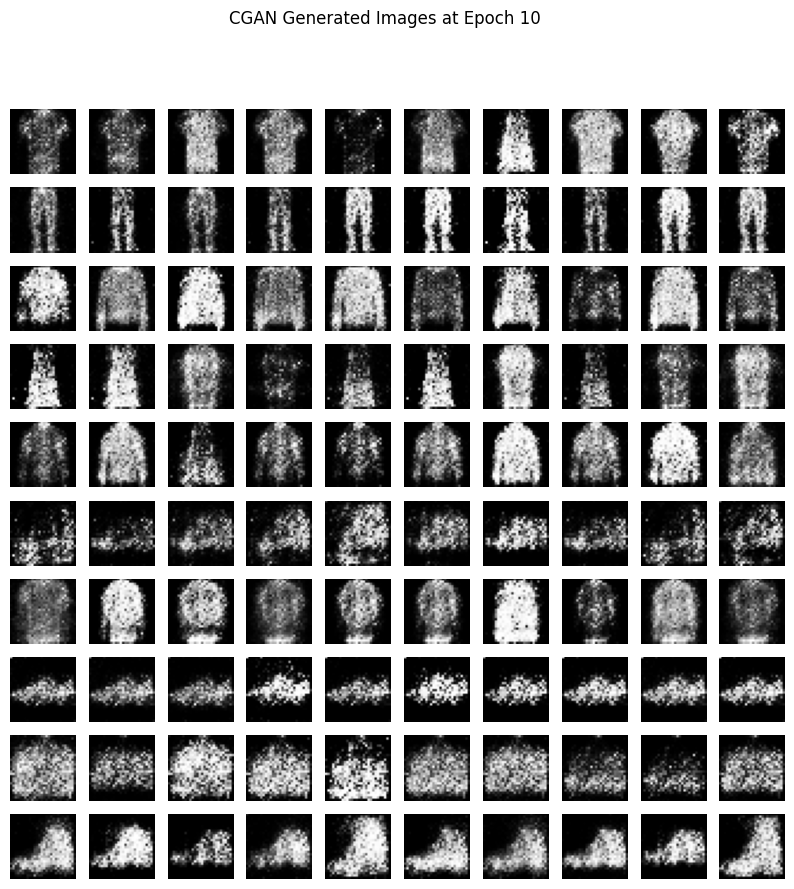

Epoch [11/20] | D loss: 0.5121 | G loss: 1.0132
Epoch [12/20] | D loss: 0.5553 | G loss: 0.8226
Epoch [13/20] | D loss: 0.5647 | G loss: 1.0237
Epoch [14/20] | D loss: 0.6430 | G loss: 0.9750
Epoch [15/20] | D loss: 0.6165 | G loss: 0.8438


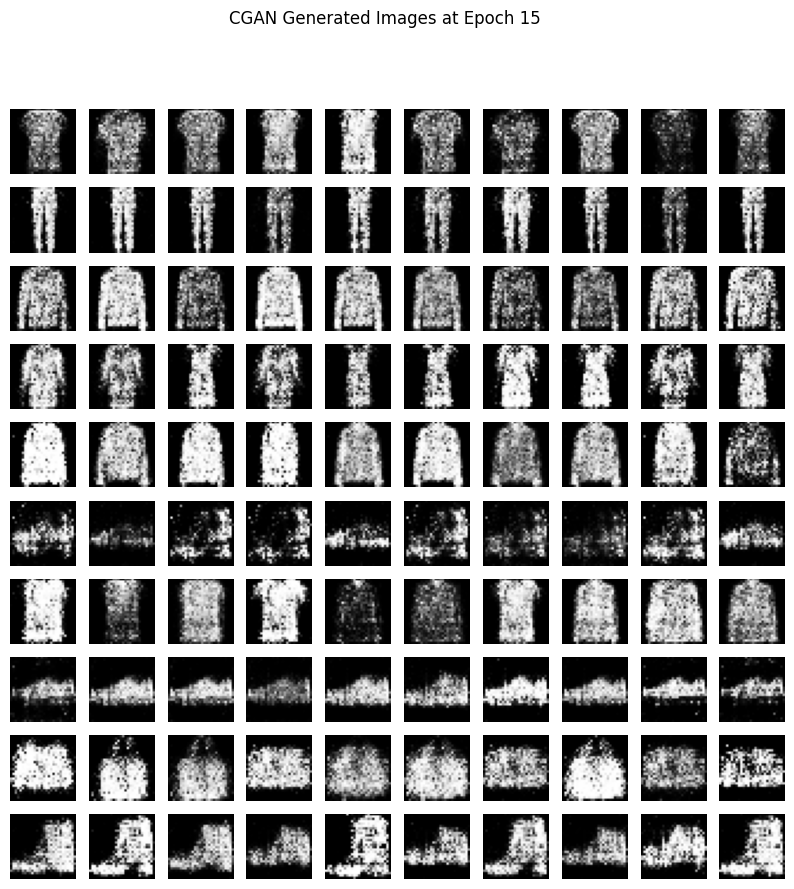

Epoch [16/20] | D loss: 0.5671 | G loss: 0.9705
Epoch [17/20] | D loss: 0.6343 | G loss: 1.1652
Epoch [18/20] | D loss: 0.6268 | G loss: 0.8701
Epoch [19/20] | D loss: 0.5836 | G loss: 1.0316
Epoch [20/20] | D loss: 0.6113 | G loss: 0.9072


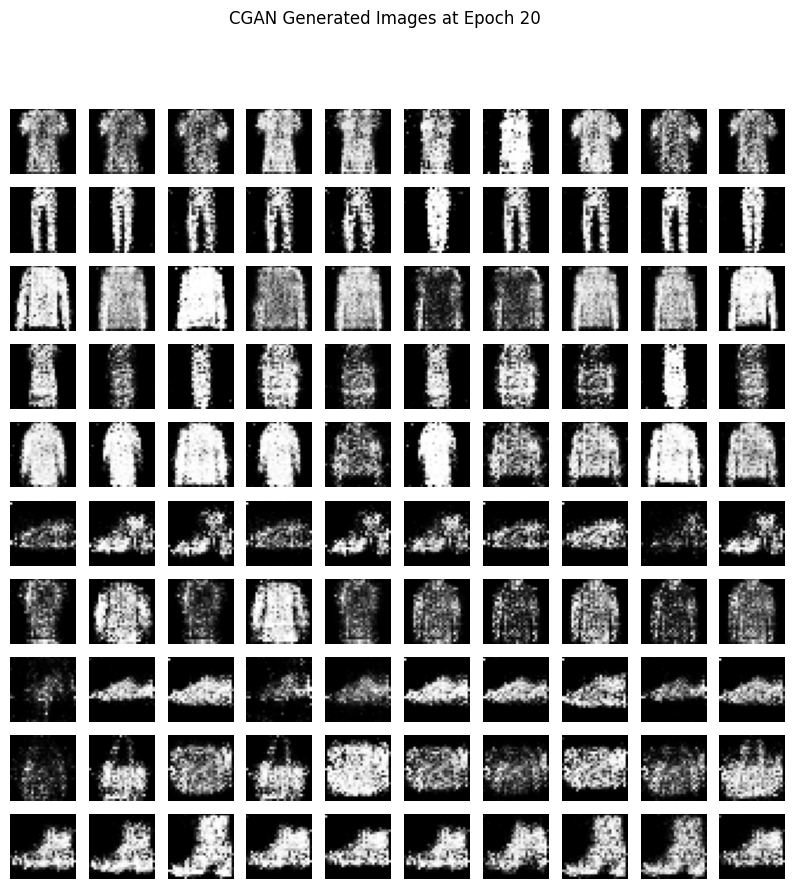

In [ ]:
G_losses, D_losses = [], []

for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_curr = imgs.size(0)

        real = torch.ones(batch_size_curr, 1).to(device)
        fake = torch.zeros(batch_size_curr, 1).to(device)

        imgs, labels = imgs.to(device), labels.to(device)

        # --------------------
        # Train Generator
        # --------------------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size_curr, z_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size_curr,)).to(device)
        gen_imgs = generator(z, gen_labels)
        g_loss = criterion(discriminator(gen_imgs, gen_labels), real)
        g_loss.backward()
        optimizer_G.step()

        # --------------------
        # Train Discriminator
        # --------------------
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(imgs, labels), real)
        fake_loss = criterion(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Append losses to lists
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())


    print(f"Epoch [{epoch+1}/{epochs}] | D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

    # Save conditional samples every 5 epochs
    if (epoch + 1) % 5 == 0:
        save_generated_images(generator, epoch+1)

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(G_losses, D_losses, title):
    plt.figure(figsize=(8, 5))
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()


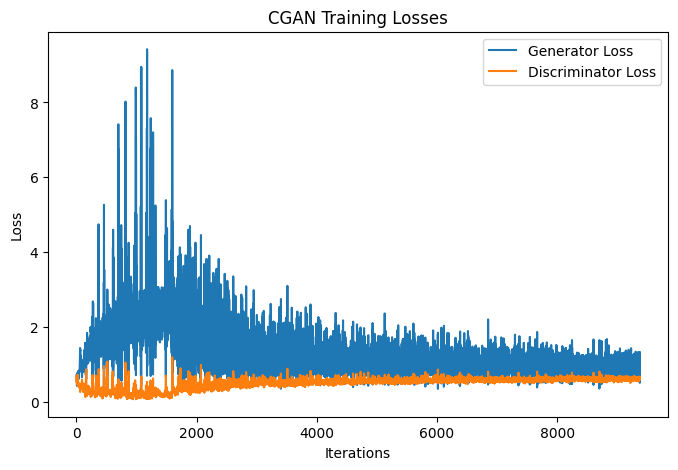

In [ ]:
plot_losses(G_losses, D_losses, "CGAN Training Losses")